In [1]:
import tensorflow as tf
import tensorflow_hub as tfhub

In [2]:
print(tf.__version__)

2.19.1


In [3]:
img_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg"
img = tf.keras.utils.get_file(fname='gangnam', origin=img_path)
img = tf.io.read_file(img)

In [4]:
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)

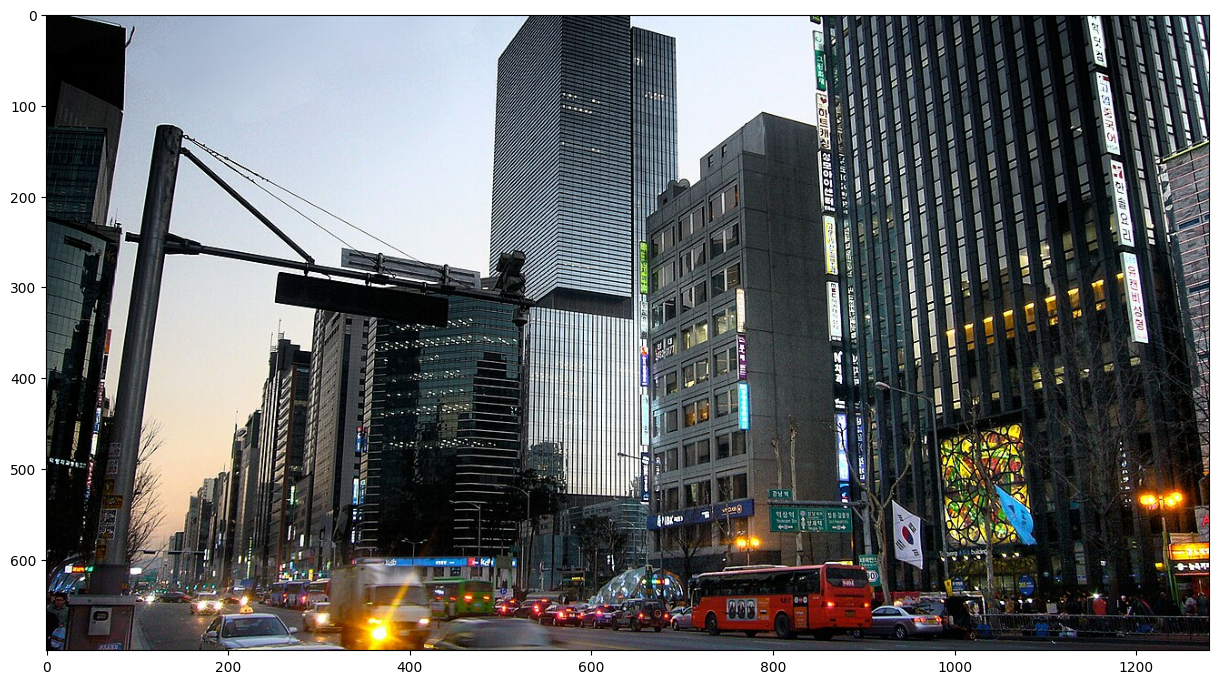

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.imshow(img)

In [6]:
# img 텐서는 3차원: 높이 x 넓이 x 채널 수
# img에 1차원을 더 추가함 -> 224 x 224 크기의 RGB 이미지로 만들기 위해서
# img.shape = (224, 224, 3)
# img1, 224, 224, 3
# tf.expand_dims(img, 0) -> img 첫번째 차원에 새로운 축을 추가함
img_input = tf.expand_dims(img, 0)

In [7]:
img_input.shape

TensorShape([1, 700, 1280, 3])

TensorShape([1, 700, 1280, 3])

- 0번째 축, 값 1: 이미지 개수(batch size) -> 이미지 한장만 처리
- 1번째 축, 값 700: height(픽셀 수)
- 2번째 축, 값 1280: width(픽셀 수)
- 3번째 축, 값 3: 채널 수(RGB)

In [8]:
# 모델 불러오기
model = tfhub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
# 모델 용도 확인
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction (images: TensorSpec(shape=(1, None, None, 3), dtype=tf.float32, name='images')) -> Dict[['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)]] at 0x2975EE56450>}))

- images: TensorSpec(shape=(1, None, None, 3)): 입력 4차원
    - 1: 이미지 한장(batch size)
    - None, None: height, width 가변 크기
    - 3: 채널 수(RGB)
- dtype=tf.float32: 입력 이미지의 자료형은 32비트 부동소수형

In [10]:
# 모델 생성
obj_detector = model.signatures['default']
obj_detector

<ConcreteFunction (images: TensorSpec(shape=(1, None, None, 3), dtype=tf.float32, name='images')) -> Dict[['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)]] at 0x2975EE56450>

In [11]:
# 모델을 이용해서 예측
result = obj_detector(img_input)
result.keys()

dict_keys(['detection_scores', 'detection_class_names', 'detection_class_entities', 'detection_boxes', 'detection_class_labels'])

In [12]:
# detect한 객체의 개수
len(result['detection_class_names'])

100

In [13]:
boxes = result['detection_boxes']
labels = result['detection_class_labels']
scores = result['detection_scores']

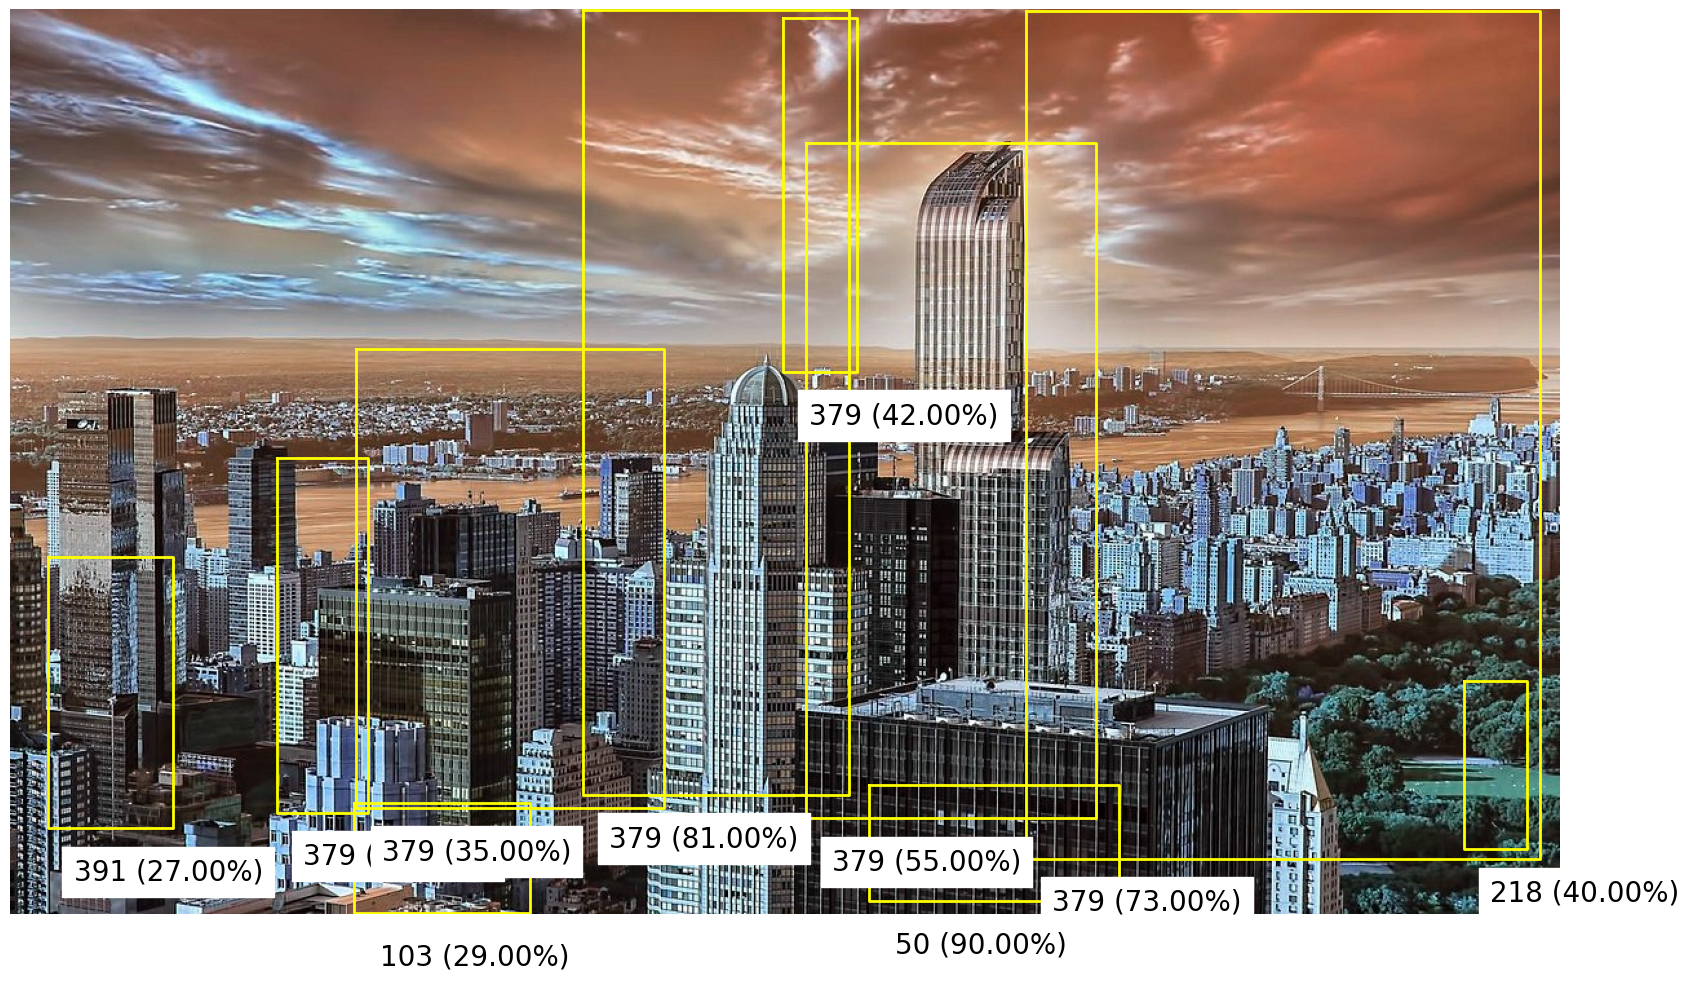

In [30]:
# 모델이 실제로 탐지한 객체의 수와 비교해서 실행
# obj_to_detect: 우리가 탐지하고자 하는 최대 객체 수
# boxes.shape[0]: 모델이 실제로 탐지한 객체 수
import cv2

img = cv2.imread('image.jpg')
img_height, img_width = img.shape[:2]
obj_to_detect = 10
plt.figure(figsize=(20, 15))
plt.axis('off')

for i in range(min(obj_to_detect, boxes.shape[0])):

    # 신뢰도(Confidence)가 0.2 이상인 경우만 시각화
    if scores[i] >= 0.2:
        # Bounding Box 좌표 계산 하기
        # boxes[i] : 0 ~ 1 사이의 상대 좌표값
        (ymin, xmin, ymax, xmax) = (boxes[i][0]*img_height, # ymin(상단)
                                    boxes[i][1]*img_width,  # xmin(좌측)
                                    boxes[i][2]*img_height, # ymax(하단)
                                    boxes[i][3]*img_width)  # xmax(우측)
        plt.imshow(img)
        # x 좌표[xmin, xmax, xmax, xmin, xmin]와 y 좌표[ymin, ymin, ymax, ymax, ymin]로 
        # 설정하여 직사각형 형태의 Bounding Box를 그림
        # 
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],
                color ='yellow', linewidth=2)
        
        class_name = labels[i].numpy()
        # Object(객체)의 신뢰도를 가져와서 0~1 사이값을 X 100 => 백분율 형태로 변환
        infer_score = int(scores[i].numpy()*100)
        annotation = f'{class_name} ({infer_score:.2f}%)'
        # annotation = "{}: {}%".format(class_name, infer_score)
        plt.text(xmin+20, ymax+40, annotation,
                color = 'black', backgroundcolor='white', fontsize=20)    